In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons

import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda


  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-qgjtu11l
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-qgjtu11l
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done




> Reading Dataset &



In [ ]:
working_dir = '/kaggle/working'


for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")


❌ xóa thành công /kaggle/working/model


In [ ]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    """
    Đọc và xử lý dữ liệu từ ISIC 2017 dataset

    Args:
        image_path: Đường dẫn đến thư mục chứa ảnh gốc
        mask_path: Đường dẫn đến thư mục chứa mask
        binary_path: Đường dẫn đến thư mục chứa mask nhị phân
        csv_file: Đường dẫn đầy đủ đến file CSV chứa nhãn
        label_name: Tên cột chứa nhãn trong file CSV
        img_size: Kích thước ảnh đầu ra (width, height)

    Returns:
        images: Numpy array chứa các ảnh đã xử lý
        masks: Numpy array chứa các mask đã xử lý
        binary_masks: Dict chứa mask nhị phân của từng ảnh đã xử lý
        image_ids: List các ID của ảnh
        labels: List các nhãn tương ứng với ảnh
    """

    # Lấy danh sách các file ảnh
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))

    # Khởi tạo lists để lưu dữ liệu
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []

    # Đọc file CSV
    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        # Lấy image ID
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        # Kiểm tra file mask có tồn tại
        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:


            # Đọc ảnh gốc
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB


            # Đọc mask
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            # Resize ảnh và mask
            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            # Normalize
            img = img / 255.0
            mask = mask / 255.0

            # Đọc mask nhị phân
            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            # Lấy nhãn tương ứng
            label = mel_label[index]

            # Thêm vào lists
            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    # Chuyển sang numpy arrays
    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  # Thêm channel dimension cho masks
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [ ]:
# Đọc tập training
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Train_Data',
    mask_path='/kaggle/input/isic-2750/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Train_GroundTruth_2',
    csv_file="/kaggle/input/isic-2750/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 1925/1925 [05:24<00:00,  5.93it/s]



Đã đọc thành công 1925 ảnh
Shape của images: (1925, 256, 256, 3)
Shape của masks: (1925, 256, 256, 1)
Shape của labels: (1925,)


In [ ]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Test_Data',
    mask_path='/kaggle/input/isic-2750/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Test_GroundTruth_2',
    csv_file='/kaggle/input/isic-2750/Test_GroundTruth_3.csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 825/825 [02:18<00:00,  5.96it/s]



Đã đọc thành công 825 ảnh
Shape của images: (825, 256, 256, 3)
Shape của masks: (825, 256, 256, 1)
Shape của labels: (825,)


In [ ]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [ ]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    """Tính Dice hoặc Jaccard coefficient/loss cho TensorFlow hoặc NumPy."""
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

# Hàm TensorFlow
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

# Hàm NumPy
def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [ ]:
!pip install keras-retinanet

In [ ]:
def fam_module(input_features):
    """
    Feature Attention Module (FAM) với channel attention và spatial attention.
    """
    filters = input_features.shape[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_features)
    max_pool = GlobalMaxPooling2D()(input_features)

    # MLP cho channel attention
    dense1 = Dense(filters // 8, activation='relu')
    dense2 = Dense(filters, activation='sigmoid')

    avg_out = dense2(dense1(avg_pool))
    max_out = dense2(dense1(max_pool))

    # Kết hợp channel attention
    channel_attention = Add()([avg_out, max_out])
    channel_attention = Reshape((1, 1, filters))(channel_attention)
    channel_refined = Multiply()([input_features, channel_attention])

    # Spatial Attention
    # Sử dụng Lambda layer với Keras backend operations
    avg_spatial = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_refined)
    max_spatial = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_refined)
    spatial_concat = Concatenate()([avg_spatial, max_spatial])

    # Convolution để tạo spatial attention map
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(spatial_concat)
    refined_features = Multiply()([channel_refined, spatial_attention])

    return refined_features

def CustomSegUNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # ============= Encoder =============
    # Block 1
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(inputs)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c1)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = SpatialDropout2D(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p1)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c2)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = SpatialDropout2D(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p2)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c3)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = SpatialDropout2D(0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = SeparableConv2D(384, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p3)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    c4 = SeparableConv2D(384, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c4)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    c4 = SpatialDropout2D(0.1)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Block 5
    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p4)
    c5 = BatchNormalization()(c5)
    c5 = ReLU()(c5)
    c5 = SpatialDropout2D(0.1)(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    # ============= Bottleneck =============
    c6 = SeparableConv2D(1024, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal(), dilation_rate=(2, 2))(p5)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)
    c6 = SpatialDropout2D(0.2)(c6)


    # ============= Decoder =============
    u7 = Conv2DTranspose(512, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c6)
    u7 = Concatenate()([u7, c5])
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u7)
    c7 = BatchNormalization()(c7)
    c7 = ReLU()(c7)
    c7 = fam_module(c7)

    u8 = Conv2DTranspose(384, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c7)
    u8 = Concatenate()([u8, c4])
    c8 = SeparableConv2D(384, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u8)
    c8 = BatchNormalization()(c8)
    c8 = ReLU()(c8)
    c8 = fam_module(c8)

    u9 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c8)
    u9 = Concatenate()([u9, c3])
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u9)
    c9 = BatchNormalization()(c9)
    c9 = ReLU()(c9)
    c9 = fam_module(c9)

    u10 = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c9)
    u10 = Concatenate()([u10, c2])
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u10)
    c10 = BatchNormalization()(c10)
    c10 = ReLU()(c10)
    c10 = fam_module(c10)

    u11 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c10)
    u11 = Concatenate()([u11, c1])
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u11)
    c11 = BatchNormalization()(c11)
    c11 = ReLU()(c11)
    c11 = fam_module(c11)


    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

    return Model(inputs=inputs, outputs=outputs)

# Khởi tạo và kiểm tra mô hình
if __name__ == "__main__":
    model = CustomSegUNet()
    model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_30       │ (None, 256, 256, 64)   │            137 │ input_layer_2[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 256, 256, 64)   │            256 │ separable_conv2d_30[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_30 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_31       │ (None, 256, 256, 64)   │          4,736 │ re_lu_30[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 256, 256, 64)   │            256 │ separable_conv2d_31[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_31 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_12      │ (None, 256, 256, 64)   │              0 │ re_lu_31[0][0]         │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 128, 128, 64)   │              0 │ spatial_dropout2d_12[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_32       │ (None, 128, 128, 128)  │          8,896 │ max_pooling2d_10[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 128, 128, 128)  │            512 │ separable_conv2d_32[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_32 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_33       │ (None, 128, 128, 128)  │         17,664 │ re_lu_32[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 128, 128, 128)  │            512 │ separable_conv2d_33[0… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 10,020,193 (38.22 MB)

 Trainable params: 10,011,105 (38.19 MB)

 Non-trainable params: 9,088 (35.50 KB)

In [ ]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')  # Khởi tạo giá trị accuracy tốt nhất là âm vô cực
        self.consecutive_stops = 0  # Đếm số lần dừng liên tiếp

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [ ]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
def convert_to_gray_clahe(images):
    grays = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # tạo đối tượng CLAHE

    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # chuyển sang ảnh xám

        img_clahe = clahe.apply(gray)  # áp dụng CLAHE
        grays.append(img_clahe)

    return np.array(grays)

# Gọi hàm
train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

In [ ]:
# Khởi tạo mô hình
model = CustomSegUNet(input_size=(256, 256, 1))

# Load weights từ file .weights.h5
model.load_weights('/kaggle/input/gray_2750/keras/default/1/gray2750.weights.h5')

initial_lr = 0.001

optimizer = Adam(learning_rate=initial_lr)

model.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)

In [ ]:
# Hàm hậu xử lý bằng Morphological Operations
def apply_morphology(mask, kernel_size=3, iterations=1):
    """
    Morphological post-processing: closing -> opening để loại bỏ nhiễu và lỗ hổng.
    - kernel_size: Kích thước kernel (7).
    - iterations: Số lần áp dụng phép toán (1 or 2).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8)  # Ngưỡng hóa trước

    # Closing để lấp lỗ hổng nhỏ
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    # Opening để loại bỏ nhiễu
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32)  # Chuyển về float để tính toán metrics


print("🔍 Đánh giá không hậu xử lý...")
results = model.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")


print("\n🔧 Đánh giá sau Morphology...")
predictions1 = model.predict(test_images_gray_clahe)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_clahe))):
    pred = predictions1[i].squeeze()  # Loại bỏ chiều batch nếu cần

    # Áp dụng Morphological Operations
    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)


# Chuyển sang numpy array và thêm chiều channel nếu cần
refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)

# Tính toán metrics
accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - accuracy: 0.9555 - jaccard_coefficient: 0.8084 - loss: 0.1081
Không hậu xử lý - Dice Loss: 0.1395, Accuracy: 95.14%, Jaccard: 76.06%

🔧 Đánh giá sau Morphology...
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 416ms/step


100%|██████████| 825/825 [00:00<00:00, 1757.77it/s]


Sau Morphology - Dice Loss: 0.1240, Accuracy: 95.16%, Jaccard: 77.94%


In [ ]:
def apply_crf(original_image, model_output):
    """Áp dụng CRF để tinh chỉnh phân đoạn."""
    H, W = original_image.shape[:2]
    model_output = np.squeeze(model_output)
    probs = np.stack([1.0 - model_output, model_output], axis=0)

    d = dcrf.DenseCRF2D(W, H, 2)
    d.setUnaryEnergy(unary_from_softmax(probs))
    d.addPairwiseGaussian(sxy=3, compat=3)

    if len(original_image.shape) == 2:
        original_image = original_image[..., np.newaxis]
    if original_image.shape[-1] == 3:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)[..., np.newaxis]

    pairwise_energy = create_pairwise_bilateral(sdims=(80, 80), schan=(13,), img=original_image.astype(np.uint8), chdim=2)
    d.addPairwiseEnergy(pairwise_energy, compat=10)

    Q = d.inference(10)
    return np.argmax(Q, axis=0).reshape((H, W))



# Đánh giá mô hình
print("Đánh giá trước CRF...")
print(f"Trước CRF - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

# Áp dụng CRF và đánh giá
print("\nĐánh giá sau CRF...")
predictions2 = model.predict(test_images_gray_clahe)
refined_predictions2 = []

for i in range(len(test_images_gray_clahe)):
    img = test_images_gray_clahe[i]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    refined_pred = apply_crf(img, predictions2[i])
    refined_predictions2.append(refined_pred)

refined_predictions2 = np.array(refined_predictions2)
accuracy_after = np_accuracy(test_masks, refined_predictions2)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions2)
loss_after = np_dice_loss(test_masks, refined_predictions2)

print(f"Sau CRF - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

Đánh giá trước CRF...
Trước CRF - Dice Loss: 0.1395, Accuracy: 95.14%, Jaccard: 76.06%

Đánh giá sau CRF...
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step
Sau CRF - Dice Loss: 0.1245, Accuracy: 95.15%, Jaccard: 77.85%


In [ ]:
def show_predictions_with_metrics_grid(refined_predictions1,
                                       images, masks,
                                       indices,
                                       save_path):

    num_images = len(indices)
    plt.figure(figsize=(8, 4 * num_images))  # 2 cột, num_images hàng

    for i, idx in enumerate(indices):
        image = images[idx]
        true_mask = masks[idx]
        pred_morph = refined_predictions1[idx]

        # Resize pred_morph về cùng kích thước với true_mask nếu cần
        if pred_morph.shape != true_mask.shape:
            pred_morph = cv2.resize(pred_morph, (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Tính metrics
        accuracy = np_accuracy(true_mask, pred_morph)

        # Cột 1: Ảnh gốc
        ax1 = plt.subplot(num_images, 2, 2*i + 1)
        ax1.imshow(image)
        # ax1.set_title(f"Ảnh gốc - idx {idx}", fontsize=14)
        ax1.axis('off')

        # Cột 2: Ảnh morphology + metrics
        ax2 = plt.subplot(num_images, 2, 2*i + 2)
        ax2.imshow(pred_morph, cmap='gray')
        # ax2.set_title("Hậu xử lý Morphology", fontsize=14)
        ax2.axis('off')
        ax2.text(0.5, -0.01,
                 f"Accuracy: {accuracy:.3f}",
                 fontsize=10, ha='center', va='top', transform=ax2.transAxes)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

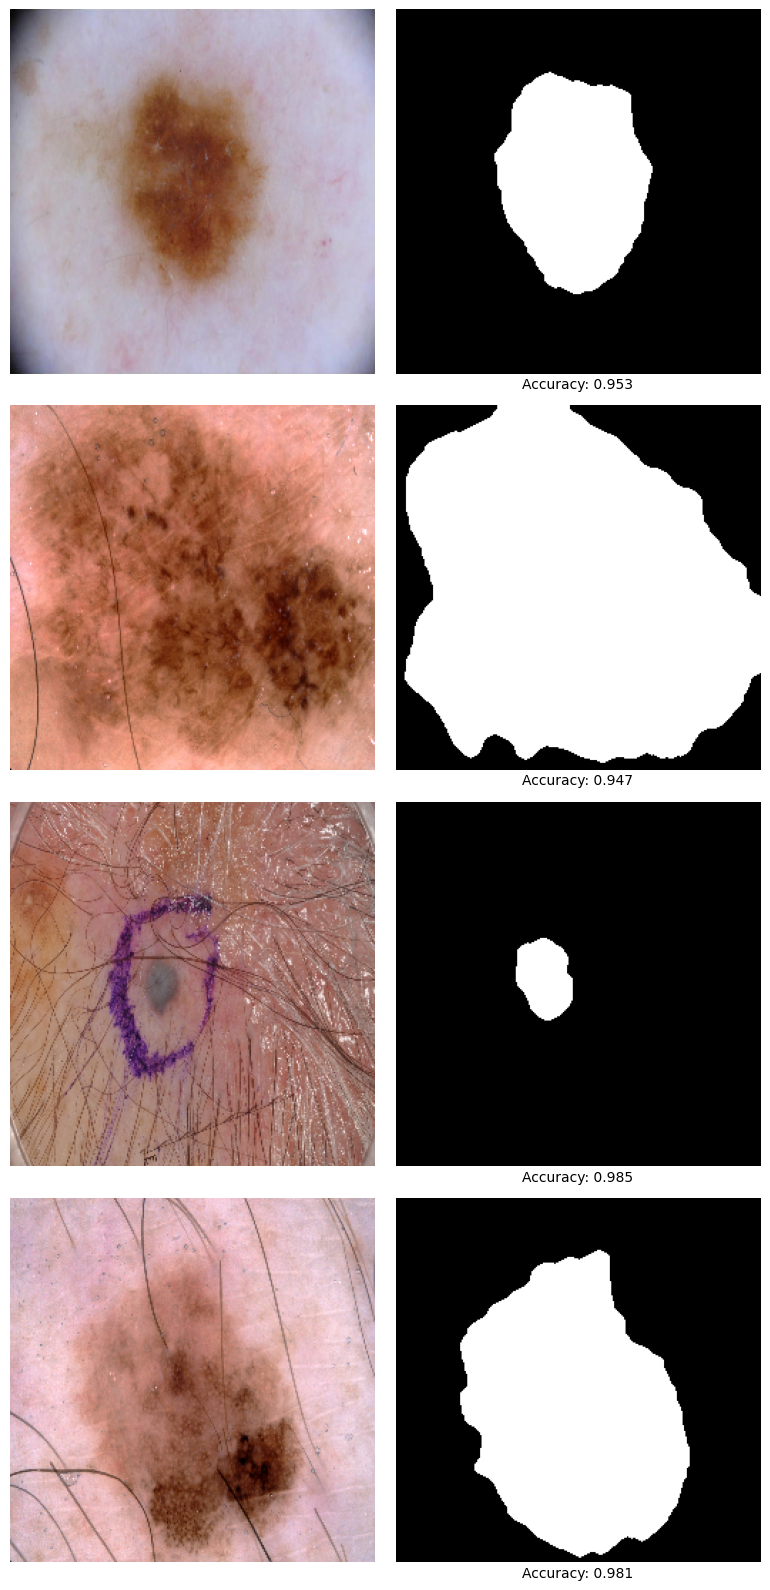

In [ ]:
show_predictions_with_metrics_grid(
    refined_predictions1=refined_predictions1,
    images=test_images,
    masks=test_masks,
    indices=[4, 555, 444, 572], # 4 ảnh
    save_path="/kaggle/working/model2750.png"
)